In [15]:
!pip install torch torchvision torchaudio
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached matplotlib-3.10.8-cp311-cp311-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp311-cp311-macosx_10_9_universal2.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
Using cached matplotlib-3.10.8-cp311-cp311-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl (270 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp311-cp311-macosx_10_9_universal2.whl (2.9 MB)
Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl (65 kB)
Using cached pyparsing-3.3.2-py3-none-any.whl (122 kB)

[notice] A new

# Convolutional Neural Networks - Build Model
---
In this notebook, we build and train a **CNN** to classify images from the CIFAR-10 database. 
* The code provided here are **almost** working. You are required to build up a CNN model and train it.
* Make sure you covered implementations of the **TODO**s in this notebook

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='cifar_data.png' width=50% height=50% />

### Optional: Use [CUDA](http://pytorch.org/docs/stable/cuda.html) if Available

Since these are color (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, but they utilize GPU's for effcient parallel computation.

In [120]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)
---
Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [131]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=train_transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=test_transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

/Users/alexander/.pyenv/versions/3.11.9/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


### Visualize a Batch of Training Data

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

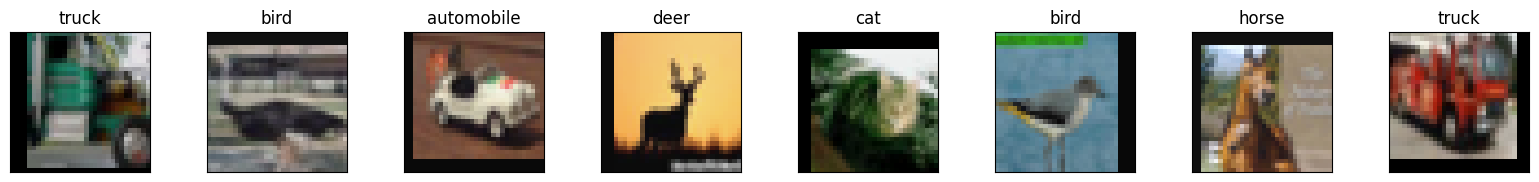

In [134]:
# obtain one batch of training images
dataiter = iter(train_loader)
#images, labels = dataiter.next() #python, torchvision version match issue
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(8):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

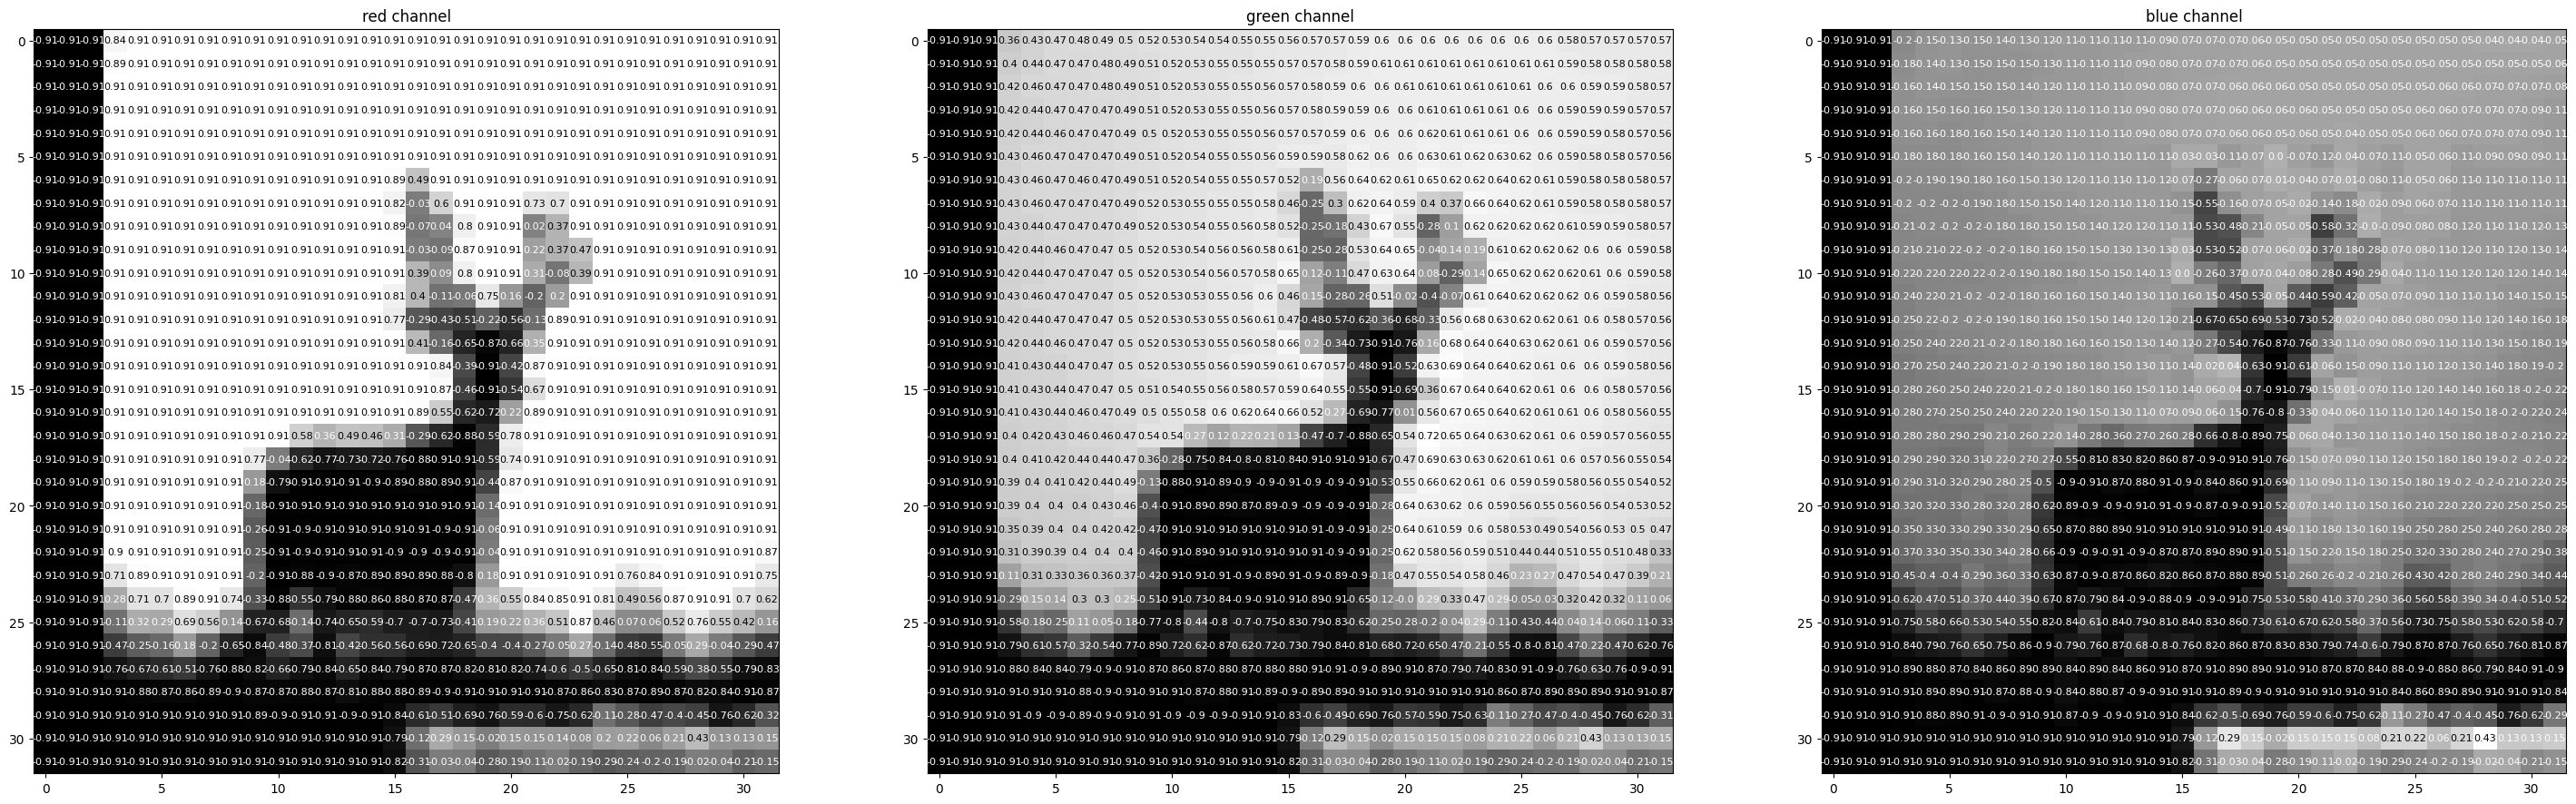

In [135]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## **TODO**: Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)
---
Build up your own Convolutional Neural Network using Pytorch API:
- nn.Conv2d(): for convolution
- nn.MaxPool2d(): for maxpooling (spatial resolution reduction)
- nn.Linear(): for last 1 or 2 layers of fully connected layer before the output layer.
- nn.Dropout(): optional, [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) can be used to avoid overfitting.
- F.relu(): Use ReLU as the activation function for all the hidden layers

The following is a skeleton example that's not completely working. 

In [136]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # TOTO: Build multiple convolutional layers (sees 32x32x3 image tensor in the first hidden layer)
        # for example, conv1, conv2 and conv3
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # TODO: Build some linear layers (fully connected)
        # for example, fc1 and fc2
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

        # TODO: dropout layer (p=0.25, you can adjust)
        # example self.dropout = nn.Dropout(0.25)
        self.dropout = nn.Dropout(0.35)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        # assume we have 2 convolutional layers defined agove
        # and we do a maxpooling after each conv layer
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # TODO: flatten x at this point to get it ready to feed into the fully connected layer(s)
        # Can use this but need to figure out the actual value for a, b and c
        # x = x.view(-1, a * b * c)
        
        x = F.relu(self.bn3(self.conv3(x)))

        x  = x.view(x.size(0), -1)

        # optional add dropout layer
        x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # optional add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)
---
Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

The following is working code, but you can make your own adjustments.

**TODO**: try to compare with ADAM optimizer

In [137]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
#optimizer = optim.SGD(model.parameters(), lr=0.01)

# TODO, compare with optimizer ADAM 
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train the Network
---
Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

Epoch: 1 	Training Loss: 3.966532 	Validation Loss: 2.319913
Validation loss decreased (inf --> 2.319913).  Saving model ...
Epoch: 2 	Training Loss: 2.319597 	Validation Loss: 2.341002
Epoch: 3 	Training Loss: 2.318856 	Validation Loss: 2.305148
Validation loss decreased (2.319913 --> 2.305148).  Saving model ...
Epoch: 4 	Training Loss: 2.318031 	Validation Loss: 2.314275
Epoch: 5 	Training Loss: 2.319846 	Validation Loss: 2.316237
Epoch: 6 	Training Loss: 2.319088 	Validation Loss: 2.320478
Epoch: 7 	Training Loss: 2.319247 	Validation Loss: 2.312374
Epoch: 8 	Training Loss: 2.317248 	Validation Loss: 2.336801
Epoch: 9 	Training Loss: 2.319773 	Validation Loss: 2.320599
Epoch: 10 	Training Loss: 2.318476 	Validation Loss: 2.318217
Epoch: 11 	Training Loss: 2.486680 	Validation Loss: 2.314210
Epoch: 12 	Training Loss: 2.318357 	Validation Loss: 2.314528
Epoch: 13 	Training Loss: 2.318878 	Validation Loss: 2.313918
Epoch: 14 	Training Loss: 2.319792 	Validation Loss: 2.310250
Epoch: 1

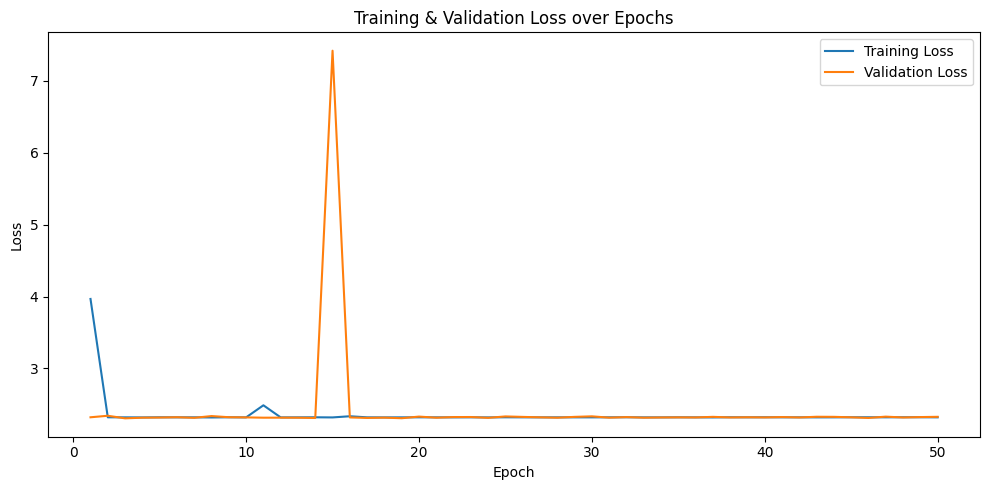

In [138]:
# number of epochs to train the model, you decide the number
n_epochs = 50

valid_loss_min = np.inf # track change in validation loss

train_losses = []
valid_losses = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_trained.pt')
        valid_loss_min = valid_loss
        
plt.figure(figsize=(10,5))
plt.plot(range(1,n_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1,n_epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()

###  Load the Model with the Lowest Validation Loss
This is the model we will use for testing, which is the model we saved in the last step

In [139]:
model.load_state_dict(torch.load('model_trained.pt'))

<All keys matched successfully>

## Test the Trained Network
---
Test your trained model on previously unseen data! Remember we have downloaded `train_data` and `test_data`. We will use `test_data` through `test_loader`.

A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

In [140]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.305321

Test Accuracy of airplane: 100% (1000/1000)
Test Accuracy of automobile:  0% ( 0/1000)
Test Accuracy of  bird:  0% ( 0/1000)
Test Accuracy of   cat:  0% ( 0/1000)
Test Accuracy of  deer:  0% ( 0/1000)
Test Accuracy of   dog:  0% ( 0/1000)
Test Accuracy of  frog:  0% ( 0/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship:  0% ( 0/1000)
Test Accuracy of truck:  0% ( 0/1000)

Test Accuracy (Overall): 10% (1000/10000)


### Visualize Sample Test Results

The following is working code, but you are encouraged to make your own adjustments and enhance the visualization.

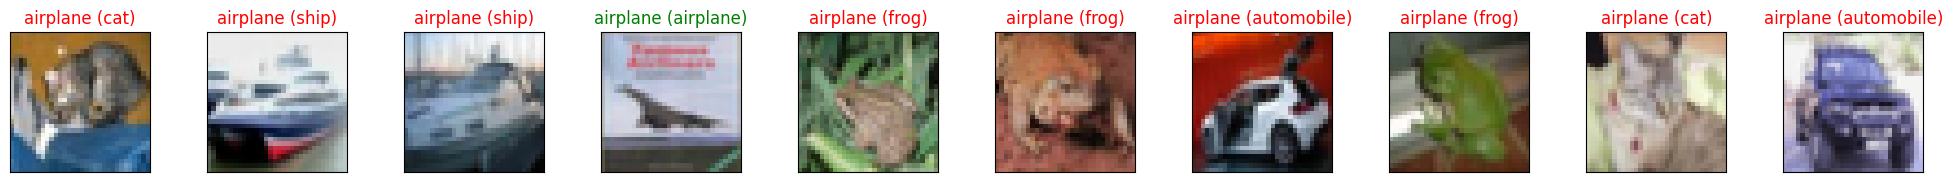

In [142]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [105]:
Targets = [1,6,8]
selected = {}

for img, label in test_data:
    if label in Targets and label not in selected: selected[label] = img
    if len(selected) == len(Targets): break

In [106]:
feature_maps = {}

def hook_fn(module,input,output): feature_maps['conv1'] = output.detach().cpu()

hook_hand = model.conv1.register_forward_hook(hook_fn)

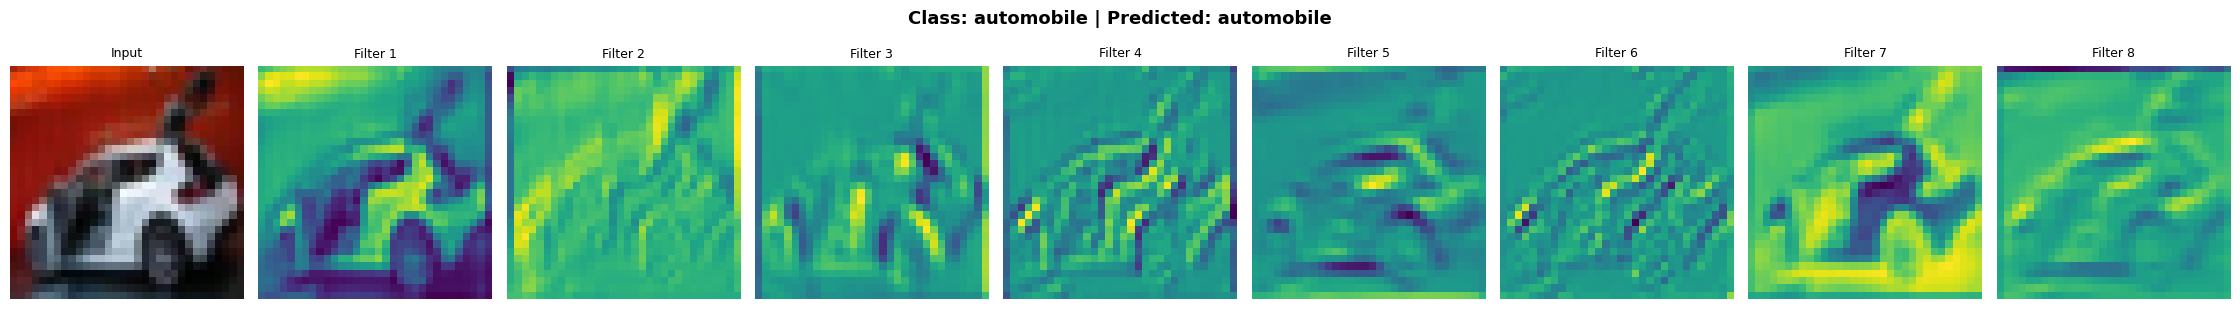

Saved: feature_maps_automobile.png


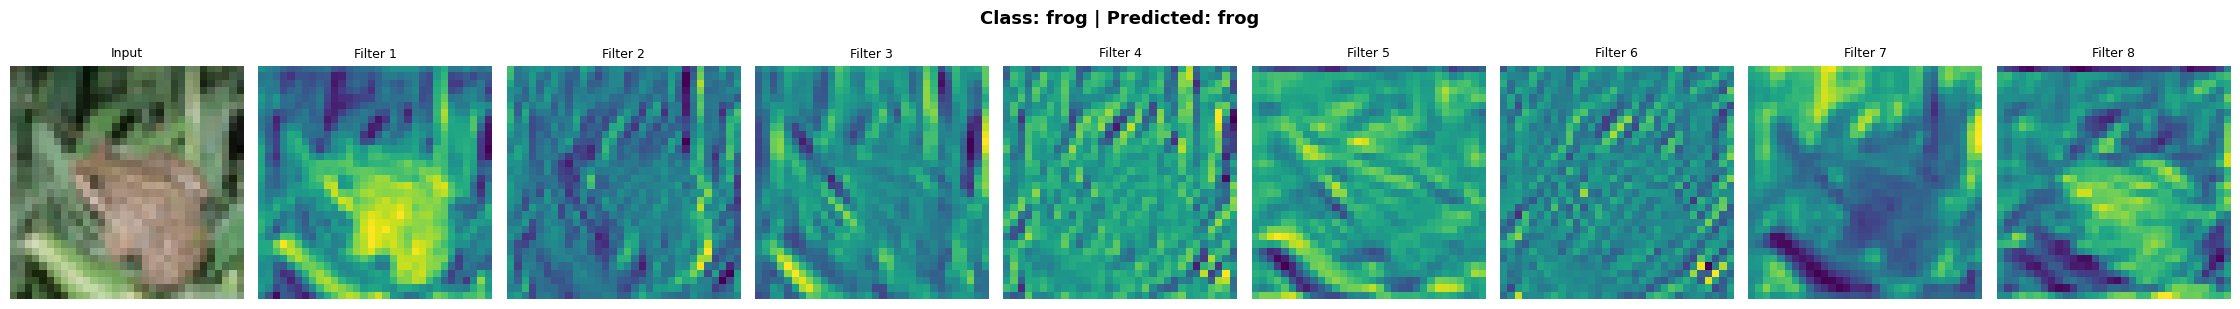

Saved: feature_maps_frog.png


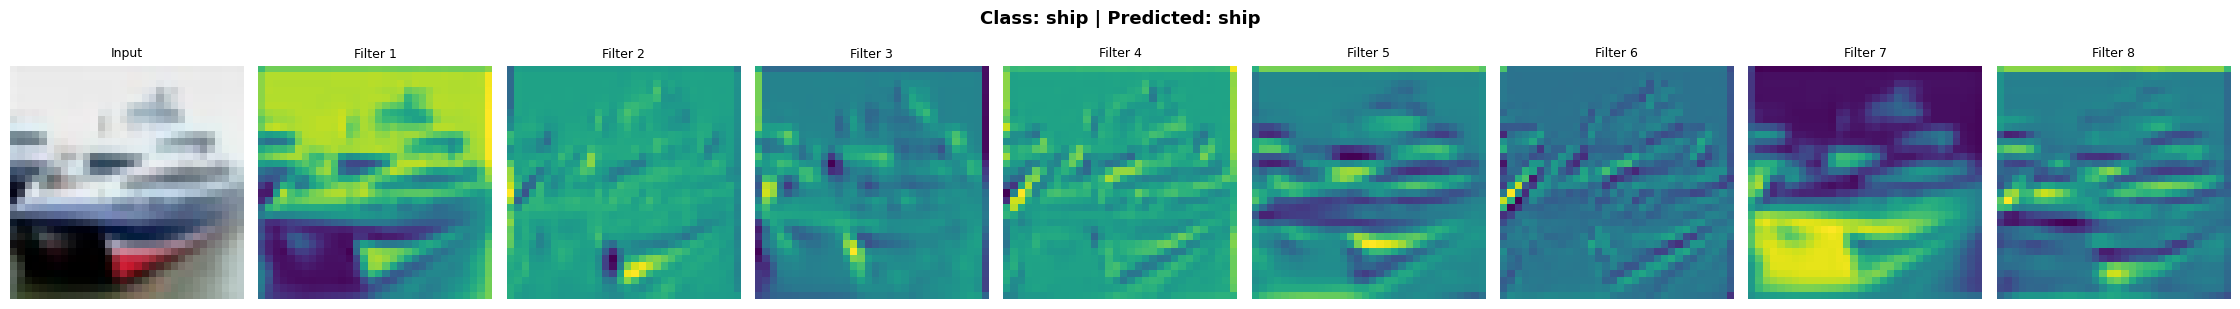

Saved: feature_maps_ship.png


In [107]:
N_Maps = 8
device = torch.device('cuda' if train_on_gpu else 'cpu')

for class_idx in Targets:
    img_tensor = selected[class_idx]
    label_name = classes[class_idx]
    
    with torch.no_grad():
        input_batch = img_tensor.unsqueeze(0).to(device)
        output = model(input_batch)
        pred_idx = output.argmax(dim=1).item()
        pred_name = classes[pred_idx]
        
    features = feature_maps['conv1'].squeeze(0)
    
    fig, axes = plt.subplots(1, N_Maps + 1, figsize=(2.5 * (N_Maps + 1), 3))
    fig.suptitle(f'Class: {label_name} | Predicted: {pred_name}', fontsize=13, fontweight='bold', y=1.02)
    
    orig = img_tensor.permute(1,2,0).numpy()
    orig = (orig * 0.5) + 0.5
    orig = np.clip(orig,0,1)
    
    axes[0].imshow(orig)
    axes[0].set_title('Input', fontsize=9)
    axes[0].axis('off')
    
    for i in range(N_Maps):
        feature = features[i].numpy()
        axes[i + 1].imshow(feature, cmap='viridis')
        axes[i + 1].set_title(f'Filter {i+1}', fontsize=9)
        axes[i + 1].axis('off')
        
    plt.tight_layout()
    plt.savefig(f'feature_maps_{label_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: feature_maps_{label_name}.png')

In [114]:
N_Filters = 32
N_Images = len(test_data)

all_activations = np.zeros((N_Images, N_Filters), dtype=np.float32)

idx = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        model(data)
        feat = feature_maps['conv1']
        mean_act = feat.mean(dim=(2,3)).numpy()
        batch_size = mean_act.shape[0]
        all_activations[idx: idx + batch_size] = mean_act
        idx += batch_size
        
print(f"Done. Activation Matrix Shape: {all_activations.shape}")
hook_hand.remove()

Done. Activation Matrix Shape: (10000, 32)


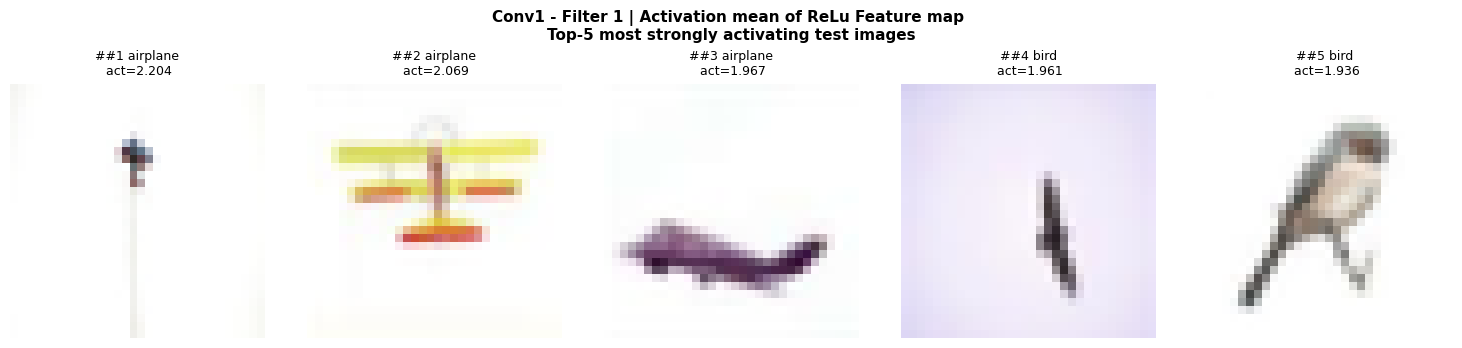

Saved : Top_5_Filter_1.png


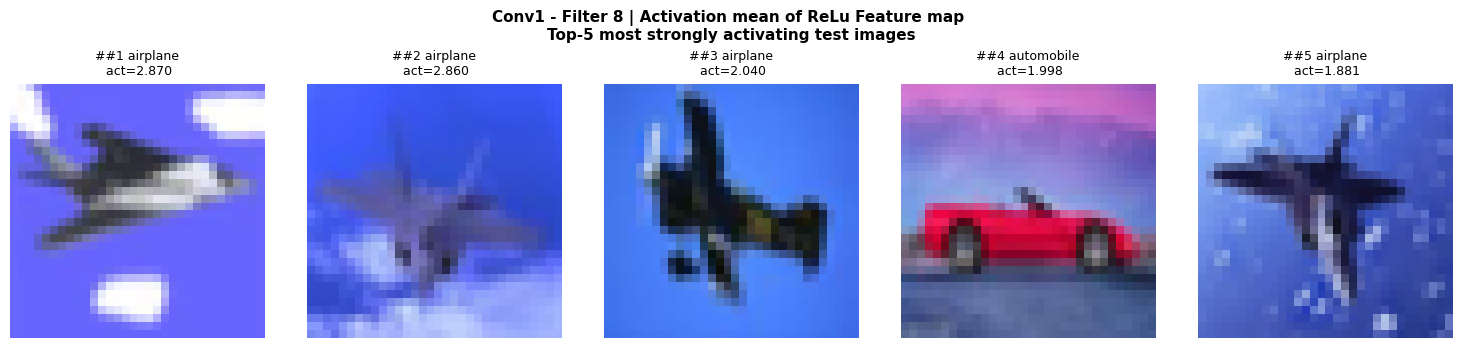

Saved : Top_5_Filter_8.png


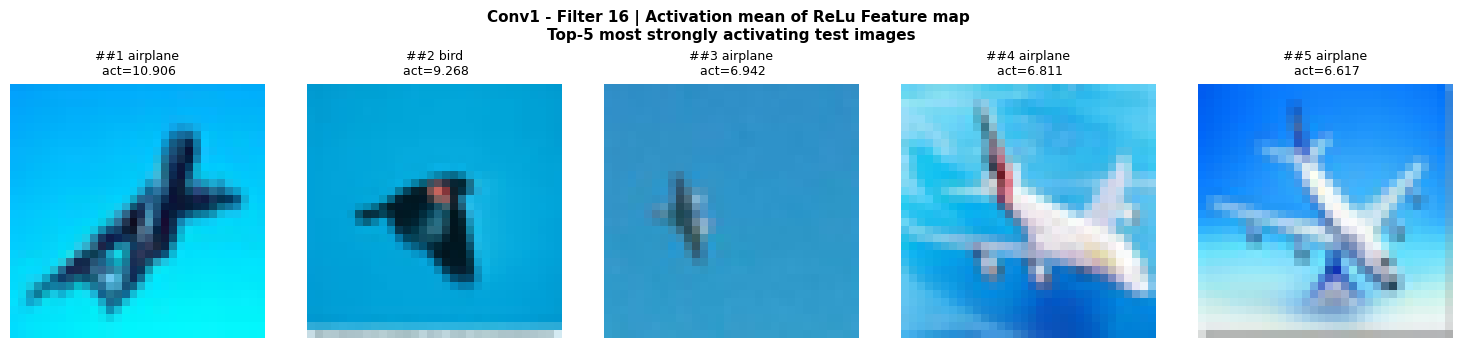

Saved : Top_5_Filter_16.png


In [118]:
Selected_Filters = [0,7,15]
Top_K = 5

def to_display(tensor):
    img = tensor.permute(1,2,0).numpy()
    img = (img * 0.5) + 0.5
    return np.clip(img,0,1)

for filter_idx in Selected_Filters:
    Scores = all_activations[:,filter_idx]
    Top5 = np.argsort(Scores)[::-1][:Top_K]
    
    fig, axes = plt.subplots(1, Top_K, figsize=(3 * Top_K, 3.5))
    fig.suptitle(f"Conv1 - Filter {filter_idx + 1} | Activation mean of ReLu Feature map \n"
                 f"Top-{Top_K} most strongly activating test images\n",
                 fontsize=11,fontweight='bold')
    
    for rank, img_idx in enumerate(Top5):
        img_tensor, label = test_data[img_idx]
        orig = to_display(img_tensor)
        score = Scores[img_idx]
        
        axes[rank].imshow(orig)
        axes[rank].set_title(f'##{rank+1} {classes[label]}\n act={score:.3f}', fontsize=9)
        axes[rank].axis('off')
        
    plt.tight_layout()
    fname = f'Top_5_Filter_{filter_idx + 1}.png'
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved : {fname}")
        